<a href="https://colab.research.google.com/github/xavierhua0129/Trading-Analysis/blob/main/ALL(log10)_VS_Date.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [76]:
import numpy as np
import pandas as pd
import plotly.express as px
from ipywidgets import Dropdown, FloatSlider, IntSlider, interact
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import datetime
import glob
import os

In [77]:
def create_df(data_dir):
    # concat all data
    file_list = glob.glob(os.path.join(data_dir, '*.csv'))
    data = []

    for file in file_list:
        df = pd.read_csv(file)
        data.append(df)

    df = pd.concat(data)

    # set Date column to datetime
    if df["Date"].str.contains("/").any():
        df["Date"] = pd.to_datetime(df['Date'], format="%m/%d/%Y")
    elif df["Date"].str.contains(",").any():
        df["Date"] = pd.to_datetime(df["Date"], format="%b %d, %Y")

    df = df.sort_values(by="Date")

    # record start date and idx
    end_date = df["Date"].iloc[-1]
    start_date = df["Date"].iloc[0]

    # clean data & set index
    df = df.drop(columns=["Open","High","Low","Vol.","Change %"])
    df = df.set_index("Date")
    df = df.resample('D').ffill()

    # change price to log10
    if df["Price"].dtypes == object :
        df["Price"] = df["Price"].str.replace(",","").astype(np.float64)
    df["Price"] = np.log10(df["Price"])

    # add Time for easier visualisation
    df["Time"] = range(0, len(df["Price"]))
    return df, start_date, end_date

In [78]:
#####change path
df, start_date, end_date = create_df(r"/content/NASDAQ100")
df

,Price,Time
Date,,
1985-09-26,2.043912,0
1985-09-27,2.043912,1
1985-09-28,2.043912,2
1985-09-29,2.043912,3
1985-09-30,2.043834,4
...,...,...
2023-04-13,4.117582,13713
2023-04-14,4.116592,13714
2023-04-15,4.116592,13715


In [79]:
X = df.drop(columns="Price")
y = df["Price"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [80]:
y_mean = y_train.mean()
y_pred_baseline = [y_mean] * len(y_train)
baseline_mae = mean_absolute_error(y_train,y_pred_baseline)
print("Baseline MAE:", baseline_mae)

Baseline MAE: 0.4533772942555647


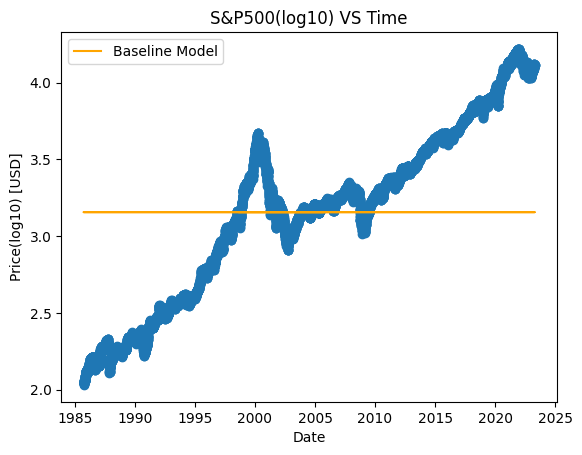

In [81]:
plt.plot(X_train.index, y_pred_baseline, color="orange", label="Baseline Model")
plt.scatter(X_train.index, y_train)
plt.xlabel("Date")
plt.ylabel("Price(log10) [USD]")
plt.title("S&P500(log10) VS Time")
plt.legend();

In [82]:
model = LinearRegression()
model.fit(X_train,y_train)

LinearRegression()

In [83]:
y_pred_training = model.predict(X_train)
training_mae = mean_absolute_error(y_train,y_pred_training)
print("Training MAE:", training_mae)

Training MAE: 0.11651033672425073


In [84]:
y_pred_test = pd.Series(model.predict(X_test))
testing_mae = mean_absolute_error(y_test,y_pred_test)
print("Testing MAE:", testing_mae)

Testing MAE: 0.11645738103180357


In [85]:
y_pred = model.predict(X)
overall_mae = mean_absolute_error(y,y_pred)
print("Overall MAE:", overall_mae)

Overall MAE: 0.11650504038294461


In [86]:
print(f"{((baseline_mae-overall_mae)/baseline_mae)*100}%")

74.30285065902048%


In [87]:
df_pred = pd.DataFrame(
    {"predicted": y_pred, "price": y}, index=X.index
)

In [88]:
fig = px.line(df_pred, labels={"value": "Price(log10)"})
fig.show()

In [89]:
coefficients = model.coef_
intercept = model.intercept_
print(f"price(log10) = {intercept} + ({coefficients[0]} * Date)")

price(log10) = 2.229973337374026 + (0.00013489883541667065 * Date)


In [90]:
def make_prediction(Time):
    data = {
        "Time": Time,
    }
    prediction_date = start_date + datetime.timedelta(days=Time)
    df =pd.DataFrame(data,index=[0])
    prediction = (10**(model.predict(df))).round(4)[0]
    return f"Predicted price on date:{prediction_date} is ${prediction}"

In [91]:
def count_num_days(end_date, start_date=start_date.date()):
    delta = end_date - start_date
    num_days = delta.days
    return num_days

In [94]:
num_days = count_num_days(datetime.date(2020, 12, 1))
print(num_days)

12850


In [93]:
interact(
    make_prediction,
    Time=IntSlider(
        min=0,
        max=20000,
        value= len(df["Time"]) - 1
    )
);

interactive(children=(IntSlider(value=13717, description='Time', max=20000), Output()), _dom_classes=('widget-…